### Creating Model 1

* Creating a 1st model for the NFL Play data. The goal is to predict the play type on 4th down.
* Random Forest and gradient boosted trees are the other models

In [2]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
import nfl_data_py as nfl
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN
from DataPipelineFxn import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [3]:
# get the spark session and data frame
data = GetSparkDF(include_undersample = True)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/03 19:20:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/03 19:20:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/03 19:20:52 WARN TaskSetManager: Stage 0 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 19:20:54 WARN TaskSetManager: Stage 3 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 19:21:01 WARN TaskSetManager: Stage 4 contains a task of very large size (2197 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:21:04 WARN TaskSetManager: Stage 5 contains a task of very large size (1216 KiB). The maximum recommended task size is 1000 KiB.


In [4]:
spark, df, test_df, undersample_df = data

### Create numeric columns list for the pipeline

In [5]:
numeric_cols = []
for field in df.schema.fields:
    if str(field.dataType) != "StringType()":
        numeric_cols.append(field.name)
        
numeric_cols.remove("season")
numeric_cols.remove("week")

In [6]:
print(numeric_cols)

['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'down', 'drive', 'qtr', 'ydstogo', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential', 'ep', 'epa', 'wind', 'temp']


### Create the Model Pipeline

In [14]:
str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half", "week",
        "play_type", "season", 'roof', 'surface']
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec", "week_vec",
                  "side_of_field_vec", "game_half_ivec", "season_vec", 'roof_vec', 'surface_vec']

# Combine numeric and one-hot encoded columns
va_input_cols = numeric_cols + ohe_col_vec

# process using string indexer first for catgeorical features  
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# process rating data into second feature
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec) 

# Assemble features column
va = VectorAssembler(inputCols=va_input_cols, outputCol="features", handleInvalid = "skip")

# process data using maxabs scaler, not necessarily important for trees but consistency
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

# define the model
lr = LogisticRegression(labelCol='play_type_idx', 
                        featuresCol='scaledFeatures')

# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler, lr])

In [15]:
# hyperparameter search across max depth, bins, and iterations
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.1, 0.09, 0.05, 0.01, 0.005]) \
    .addGrid(lr.maxIter, [50])\
    .addGrid(lr.elasticNetParam, [0.0, 0.01, 0.5, 0.8, 0.85, 0.9, 1])\
    .build()



# build the evaluator
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="play_type_idx",
    metricName="accuracy"
)

# set up the train validation split
tvs = TrainValidationSplit(
    estimator=pipeline,
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8
)

In [16]:
df.select(df.roof).distinct().show()

24/12/03 19:25:46 WARN TaskSetManager: Stage 2691 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
+--------+
|    roof|
+--------+
|outdoors|
|  closed|
|    open|
|    dome|
+--------+



In [17]:
# need to replace the empty string in surface
df = df.withColumn(
    'surface',
    F.when(df.surface == '', 'Undefined').otherwise(df.surface)
)

# fit the model with the hyperparameter search
lr_model = tvs.fit(df)

24/12/03 19:25:49 WARN TaskSetManager: Stage 2694 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:25:50 WARN TaskSetManager: Stage 2697 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:25:51 WARN TaskSetManager: Stage 2700 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:25:51 WARN TaskSetManager: Stage 2701 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:25:52 WARN TaskSetManager: Stage 2702 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:25:52 WARN TaskSetManager: Stage 2703 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:25:52 WARN TaskSetManager: Stage 2704 contains a task of very large size (6176 KiB). The maximum recommended task size is 10

24/12/03 19:26:03 WARN TaskSetManager: Stage 2822 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:03 WARN TaskSetManager: Stage 2823 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:03 WARN TaskSetManager: Stage 2824 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:04 WARN TaskSetManager: Stage 2825 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:04 WARN TaskSetManager: Stage 2826 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:04 WARN TaskSetManager: Stage 2827 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:04 WARN TaskSetManager: Stage 2828 contains a task of very large size (6176 KiB). The maximum recommended task size is 10

24/12/03 19:26:08 WARN TaskSetManager: Stage 2882 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:09 WARN TaskSetManager: Stage 2883 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:09 WARN TaskSetManager: Stage 2884 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:09 WARN TaskSetManager: Stage 2885 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:09 WARN TaskSetManager: Stage 2886 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:09 WARN TaskSetManager: Stage 2887 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:26:09 WARN TaskSetManager: Stage 2888 contains a task of very large size (6176 KiB). The maximum recommended task size is 10

24/12/03 19:28:56 WARN TaskSetManager: Stage 5312 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 19:28:57 WARN TaskSetManager: Stage 5313 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 19:28:59 WARN TaskSetManager: Stage 5314 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:28:59 WARN TaskSetManager: Stage 5315 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:28:59 WARN TaskSetManager: Stage 5316 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:28:59 WARN TaskSetManager: Stage 5317 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:28:59 WARN TaskSetManager: Stage 5318 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:28:59 WARN TaskSetManager: Stage 5319 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:28:59 WARN TaskSetManager: Stage 5320 contains a task of very large size (6176 KiB). The maximum recommended task size is 10

### Evaluate the Model

In [18]:
best_model = lr_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Parameters of the Best Model:
aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: scaledFeatures
fitIntercept: True
labelCol: play_type_idx
maxBlockSizeInMB: 0.0
maxIter: 50
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.0
standardization: True
threshold: 0.5
tol: 1e-06


In [19]:
# have to change test df instance
test_df = test_df.withColumn(
    'surface',
    F.when(test_df.surface == '', 'Undefined').otherwise(test_df.surface)
)

prediction = best_model.transform(test_df)


In [20]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

f1_score = f1_evaluator.evaluate(prediction)
accuracy = accuracy_evaluator.evaluate(prediction)
precision_by_label = precision_by_label_eval.evaluate(prediction)

24/12/03 19:29:26 WARN TaskSetManager: Stage 5366 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:29:26 WARN TaskSetManager: Stage 5367 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 19:29:29 WARN TaskSetManager: Stage 5376 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:29:30 WARN TaskSetManager: Stage 5377 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 19:29:32 WARN TaskSetManager: Stage 5386 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:29:32 WARN TaskSetManager: Stage 5387 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
prediction.select([prediction.play_type_idx, prediction.prediction]).show(10)

In [ ]:
prediction.groupby(prediction.prediction).count().show()

In [ ]:
prediction.groupby(prediction.play_type_idx).count().show()

In [21]:
labels = prediction.select([prediction.play_type, prediction.play_type_idx]).distinct().orderBy(prediction.play_type_idx).select(prediction.play_type).collect()

24/12/03 19:29:42 WARN TaskSetManager: Stage 5396 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:29:42 WARN TaskSetManager: Stage 5397 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
test_df.groupby(test_df.play_type).count().show()

In [23]:
results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
'''

print(results)


F1: 0.8467873295583606
Accuracy: 0.8675911904572142
Precision by Label: 0.9311346422531068



In [24]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('prediction')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

24/12/03 19:30:11 WARN TaskSetManager: Stage 5421 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 19:30:11 WARN TaskSetManager: Stage 5422 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


[[2.5325e+04 3.1500e+02 3.4300e+02 1.9400e+02 1.0000e+01]
 [1.5200e+02 5.8060e+03 2.3400e+02 6.9000e+01 2.0000e+00]
 [5.6000e+02 6.1500e+02 9.8600e+02 2.0300e+02 8.0000e+00]
 [3.1300e+02 4.1000e+02 1.8600e+02 5.3400e+02 5.0000e+00]
 [8.4800e+02 2.9000e+02 1.3300e+02 9.4000e+01 6.0000e+00]]


Text(95.5815972222222, 0.5, 'Actual')

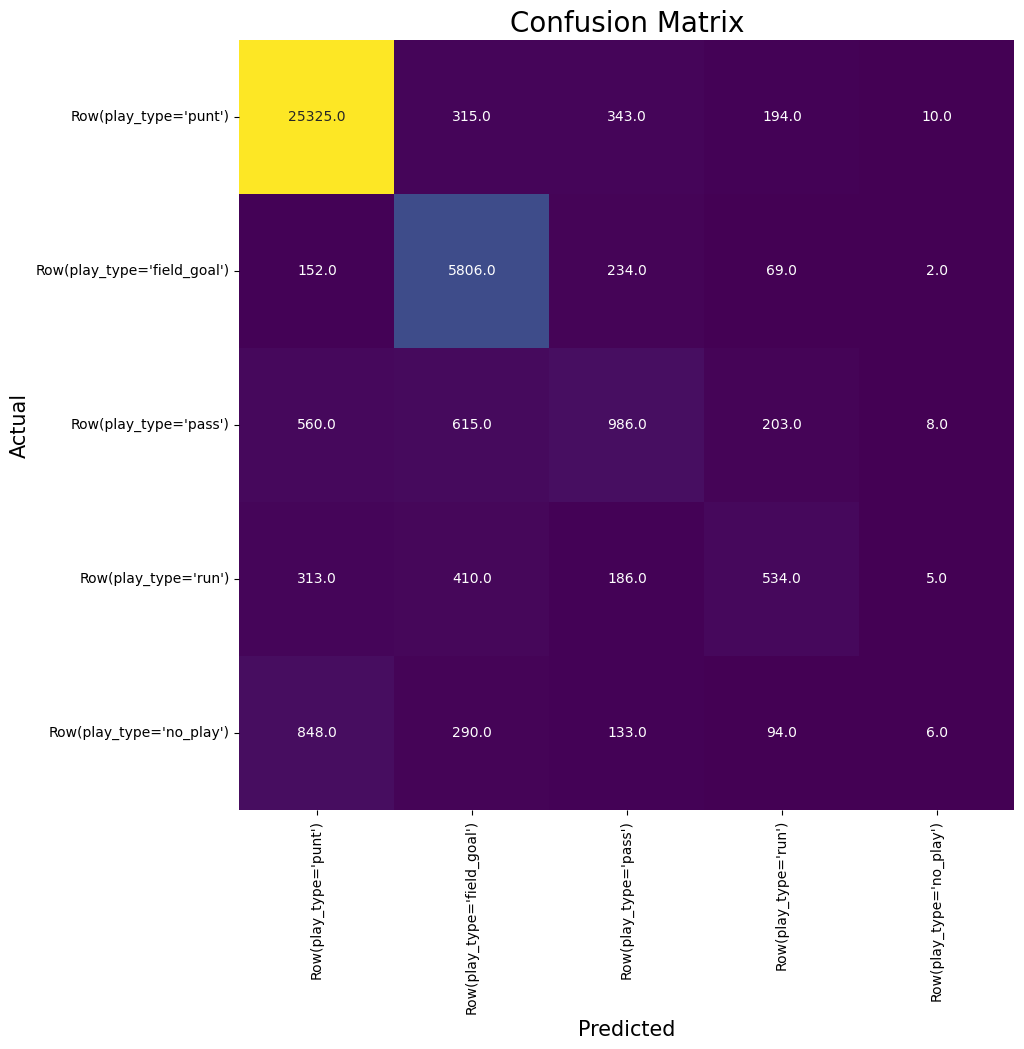

In [25]:
# labels = ["field_goal", "no_play", "pass", "punt", "run"]
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15

### Conclusions

Some quick observations:

* Much better performance when we don't undersample, could be because everything is a punt
* We need to be careful with the labels for the confusion matrix. They were not intially lining up properly with what the idxs are.
* I added temp, wind, roof, surface to the predictors